In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 读取数据集：no-filter数据、ground-truth数据集、运动控制U、测量集合Z
X_no_filter = np.load('../01GaussianFileters/dataset/no_filter.npy')
X_ground_truth = np.load('../01GaussianFileters/dataset/ground_truth.npy')
X_ekf = np.load('../01GaussianFileters/dataset/ekf.npy')
U = np.load('../01GaussianFileters/dataset/u.npy')
Z = np.load('../01GaussianFileters/dataset/z.npy')

# 粒子滤波——重采样版本

粒子滤波（Particle Filter）是贝叶斯滤波的一种非参数实现方式，以有限个参数来近似后验。粒子滤波的主要思想是用一系列从后验得到的随机状态采样表示后验$bel(x_t)$。

粒子滤波中，后验分布的样本叫做粒子（Particles），有：
$$\chi_t := x_t^{[1]} , x_t^{[2]}, \cdots , x_t^{[M]}$$
每一个粒子$x_t^{[m]} \,\, (1 \le m \le M)$是状态在时刻$t$的一个具体的实例。也可以说，一个粒子就是根据真实世界状态在时刻t的一种可能假设。$M$代表粒子集$\chi_t$的粒子数量，通常取一个较大的值，如$M=1000$。

## 粒子滤波算法（基于重要性采样）

----
01：**Algorithm Particle_filter**$( \chi_{t-1}, u_t, z_t )$**:**  

02：&emsp;&emsp;$\bar\chi_t = \chi_t = \phi$  

03：&emsp;&emsp;***for*** $m = 1$ to $M$ do  

04：&emsp;&emsp;&emsp;&emsp;***sample*** $x_t^{[m]} \sim p(x_t \, | \, u_t, x_{t-1}^{[m]})$  

05：&emsp;&emsp;&emsp;&emsp;$\omega_t^{[m]} = p ( z_t \, | \, x_t^{[m]})$  

06：&emsp;&emsp;&emsp;&emsp;$\bar\chi_t = \bar\chi_t + \langle x_t^{[m]} , \omega_t^{[m]} \rangle$  

07：&emsp;&emsp;***endfor***  

08：&emsp;&emsp;***for*** $m = 1$ to $M$ do  

09：&emsp;&emsp;&emsp;&emsp;***draw*** $i$ ***with probability*** $\propto \omega_t^{[i]}$  

10：&emsp;&emsp;&emsp;&emsp;***add*** $x_t^{[i]}$ to $\chi_t$  

11：&emsp;&emsp;***endfor***  

12：&emsp;&emsp;**return** $\chi_t$

----


## 1. 运动采样函数

运动采样方程如下所示：

$$\begin{bmatrix} x' \\ y' \\ \theta' \end{bmatrix} = 
\begin{bmatrix} 
x + (u + \delta_u ) cos (\theta + \delta_{\theta}) \\
y + (u + \delta_u ) sin (\theta + \delta_{\theta}) \\
\theta + \delta_{\theta}
\end{bmatrix}
$$

其中：
$$\delta_u \sim N(0, \sigma_u^2)$$
$$\delta_{\theta} \sim N(0, \sigma_{\theta}^2)$$

向量化版本的运动采样函数：

In [3]:
# 向量化版本的运动采样函数
# 输入： 粒子集、运动控制u
# 输出：运动采样后的粒子集
def sample_motion_model(X, u, sigma_u=0.1, sigma_theta=0.1):
    xs = X[:,0].reshape((-1,1))
    ys = X[:,1].reshape((-1,1))
    thetas = X[:,2].reshape((-1,1))
    
    delta_us = np.random.normal(loc=0, scale=sigma_u, size=(X.shape[0],1)) * u
    delta_thetas = np.random.normal(loc=0, scale=sigma_theta, size=(X.shape[0],1))
    
    thetas_sample = thetas + delta_thetas
    us_noise = u + delta_us
    
    xs_sample = xs + us_noise * np.cos(thetas_sample)
    ys_sample = ys + us_noise * np.sin(thetas_sample)
    
    X_sample = np.hstack([xs_sample, ys_sample, thetas_sample])
    
    return X_sample

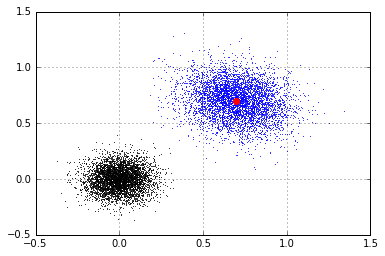

In [4]:
# 当距离和角度采样误差接近时，可以得到以下采样分布
u = 1
sigma_u = 0.1
sigma_theta=0.1

X = np.random.multivariate_normal([0,0,np.pi/4], np.diag([0.01,0.01,0.01]), size=5000)
X_sample = sample_motion_model(X, u, sigma_u=sigma_u, sigma_theta=sigma_theta)
# 黑色为原始例子，蓝色为运动采样后的粒子
plt.scatter(X[:,0], X[:,1], s=1, c='k', lw=0)
plt.scatter(X_sample[:,0], X_sample[:,1], s=1, c='b', lw=0)
mean = np.mean(X_sample, axis=0, keepdims=True)
plt.scatter(mean[:,0], mean[:,1],s=50, c='r', lw=0)
plt.grid()


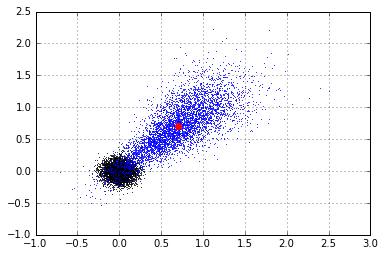

In [5]:
# 当距离误差大于角度误差时，可以得到以下采样分布
u = 1
sigma_u = 0.5
sigma_theta= 0.1

X = np.random.multivariate_normal([0,0,np.pi/4], np.diag([0.01,0.01,0.01]), size=5000)
X_sample = sample_motion_model(X, u, sigma_u=sigma_u, sigma_theta=sigma_theta)

# 黑色为原始例子，蓝色为运动采样后的粒子
plt.scatter(X[:,0], X[:,1], s=1, c='k', lw=0)
plt.scatter(X_sample[:,0], X_sample[:,1], s=1, c='b', lw=0)
mean = np.mean(X_sample, axis=0, keepdims=True)
plt.scatter(mean[:,0], mean[:,1],s=50, c='r', lw=0)
plt.grid()

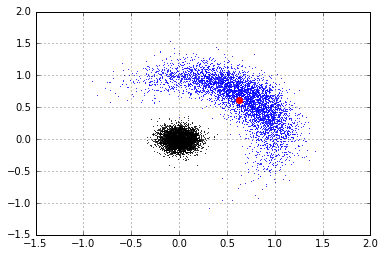

In [7]:
# 当距离误差小于角度误差时，可以得到以下采样分布
u = 1
sigma_u = 0.1
sigma_theta= 0.5

X = np.random.multivariate_normal([0,0,np.pi/4], np.diag([0.01,0.01,0.01]), size=5000)
X_sample = sample_motion_model(X, u, sigma_u=sigma_u, sigma_theta=sigma_theta)

# 黑色为原始例子，蓝色为运动采样后的粒子
plt.scatter(X[:,0], X[:,1], s=1, c='k', lw=0)
plt.scatter(X_sample[:,0], X_sample[:,1], s=1, c='b', lw=0)
mean = np.mean(X_sample, axis=0, keepdims=True)
plt.scatter(mean[:,0], mean[:,1],s=50, c='r', lw=0)
plt.grid()

## 2. 测量似然函数

测量似然函数$p(z_t \, | \, x_t^{[m]})$用来确定粒子$x_t^{[m]}$的权重，在这个仿真实验里，假设传感器可以获得到达原点的距离和当前的角度。因此似然$p(z_t \, | \, x_t^{[m]})$可以分解为：
$$p(z_t \, | \, x_t^{[m]}) = p(z_{t,distance} \, | \, x_t^{[m]}) \times p(z_{t,\theta} \, | \, x_t^{[m]})$$

其中：
$$z_{t,distance} \sim N(0, \sigma_{distance}^2)$$
$$z_{t,\theta} \sim N(0, \sigma_{\theta}^2)$$

测量似然函数的向量化版本：